In [1]:
import pandas as pd
from nixtlats import TimeGPT
from utils import add_datetime_set_index

In [2]:
# defaults to os.environ.get("TIMEGPT_TOKEN")
timegpt = TimeGPT() # token = 'my_token_provided_by_nixtla'

In [3]:
# Validating token uses up a credit, hence only do this if there is an issue with usage.
# timegpt.validate_token()

## Read the data

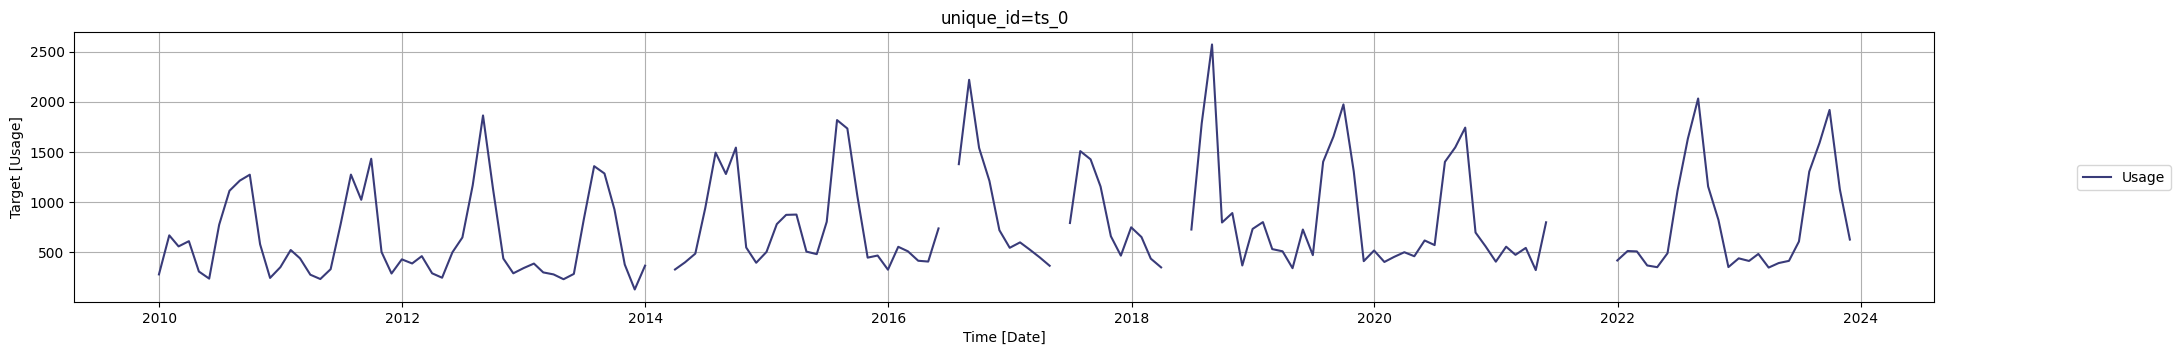

In [4]:
electricity = pd.read_csv("../data/electricity_usage.csv")

# Converting to - format since TimeGPT gives forecasts with "-" format and not "/"" format
# # TODO: This could be improved in TimeGPT
electricity['Date'] = pd.to_datetime(electricity['Date'])
electricity['Date'] = electricity['Date'].dt.strftime('%Y-%m-%d')
electricity['Date'] = pd.to_datetime(electricity['Date'])
timegpt.plot(electricity, time_col="Date", target_col='Usage')

In [5]:
electricity.head(), electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    168 non-null    datetime64[ns]
 1   Usage   156 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


(        Date  Usage
 0 2009-12-31  280.0
 1 2010-01-31  669.0
 2 2010-02-28  559.0
 3 2010-03-31  611.0
 4 2010-04-30  309.0,
 None)

## Load prior results

If you want to simply analyze the results and not use up credits unnecessarily, you can load the results from the saved ones.

| Variable Name                               | History Period | Imputation Method | Model        | Forecast Type     |
|---------------------------------------------|----------------|-------------------|--------------|-------------------|
| timegpt_fcst_df                             | Full           | Simple            | Default      | Only Future       |
| timegpt_fcst_with_history_df                | Full           | Simple            | Default      | Future + Insample |
| timegpt_fcst_df_better                      | Full           | Insample          | Default      | Only Future       |
| timegpt_fcst_with_history_df_trimmed        | Trimmed        | Simple            | Default      | Future + Insample |
| timegpt_fcst_with_history_df_trimmed_better | Trimmed        | Insample          | Default      | Only Future       |
| timegpt_fcst_with_history_df_trimmed_lh     | Trimmed        | Simple            | Long Horizon | Future + Insample |

In [6]:
REUSE = True

In [7]:
if REUSE:
    for forecast in [
        "timegpt_fcst_df",
        "timegpt_fcst_with_history_df",
        "timegpt_fcst_df_better",
        "timegpt_fcst_with_history_df_trimmed",
        "timegpt_fcst_with_history_df_trimmed_better",
        "timegpt_fcst_with_history_df_trimmed_lh"
        ]:
        ## Read the data from the data folder and save into variable with the same name as the forecast
        exec(f"{forecast} = pd.read_csv('../results/{forecast}.csv')")

## Forecast using TimeGPT

### As-Is (with missing values)

In [8]:
# Time GPT can not accept missing values in historical data
# TODO: Could be improved in TimeGPT
try:
    timegpt_fcst_df = timegpt.forecast(df=electricity, h=12, freq='M', time_col='Date', target_col='Usage')
    timegpt_fcst_df.head()
except Exception as e:
    print(e)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: M


Your target variable contains NA, please check


### Forecasting with Imputation

#### Naive Imputation

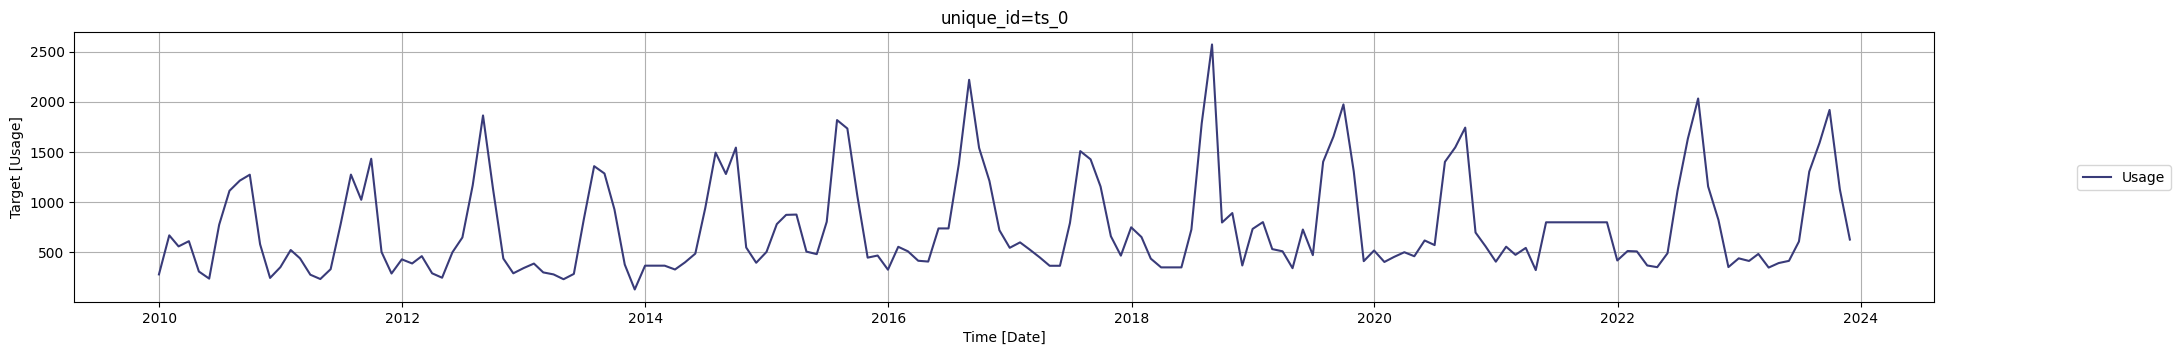

In [9]:
# Fill missing values (naive method)
electricity_filled = electricity.copy().fillna(method="ffill").fillna(method="bfill")
timegpt.plot(electricity_filled, time_col='Date', target_col='Usage')

In [10]:
if not REUSE:
    # NOTE: Calling Future forecast uses up 2 credits
    timegpt_fcst_df = timegpt.forecast(df=electricity_filled, h=12, freq='M', time_col='Date', target_col='Usage')
timegpt_fcst_df.head()
# Note: The format of the "Date" column is different from the input data.
# Input data was in the format "YYYY/MM/DD" while the forecast is in the format "YYYY-MM-DD".

,Date,TimeGPT
0,2023-12-31,562.355347
1,2024-01-31,602.121033
2,2024-02-29,597.920227
3,2024-03-31,529.268799
4,2024-04-30,497.732147


In [11]:
if not REUSE:
    # NOTE: Calling Future forecast with insample forecast uses up 2 credits
    timegpt_fcst_with_history_df = timegpt.forecast(df=electricity_filled, h=12, freq='M', time_col='Date', target_col='Usage', add_history=True)
timegpt_fcst_with_history_df.head()

,Date,TimeGPT
0,2011-12-31,369.353027
1,2012-01-31,581.588379
2,2012-02-29,523.114502
3,2012-03-31,489.358459
4,2012-04-30,278.264374


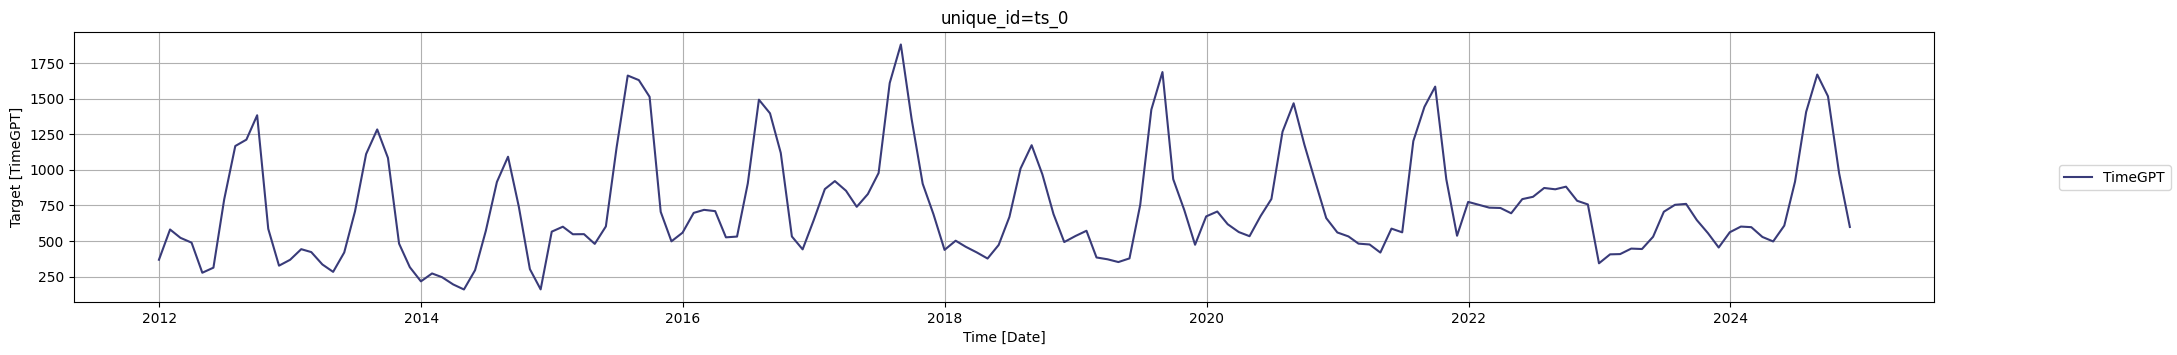

In [12]:
timegpt.plot(timegpt_fcst_with_history_df, time_col='Date', target_col='TimeGPT')

#### Imputing with Insample Predictions

In [13]:
# # Add Date as index for all dataframes
electricity = add_datetime_set_index(electricity)
timegpt_fcst_df = add_datetime_set_index(timegpt_fcst_df)
timegpt_fcst_with_history_df = add_datetime_set_index(timegpt_fcst_with_history_df)

In [14]:
# # Plot all data together (original, forecast with history)
# merged = pd.merge(electricity, timegpt_fcst_with_history_df, on="Date", how="outer")
# merged.plot(figsize=(10,4))

In [15]:
# Impute missing values in history with insample predictions
electricity_imputed_timegpt = electricity.copy()
electricity_imputed_timegpt["Usage"] = electricity_imputed_timegpt["Usage"].fillna(timegpt_fcst_with_history_df["TimeGPT"])

<AxesSubplot: xlabel='Date'>

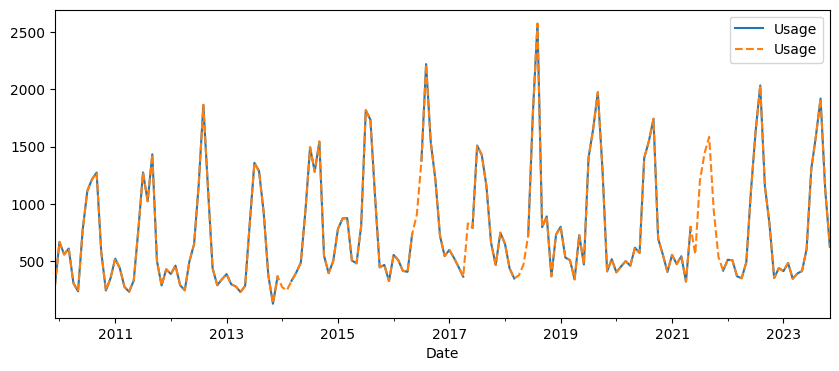

In [16]:
ax = electricity.plot(figsize=(10,4), label="Original")
# timegpt_fcst_with_history_df.plot(ax=ax)
electricity_imputed_timegpt.plot(ax=ax, label="Imputed", style="--")

In [17]:
# To Cross-check imputation
# electricity.iloc[-36:-23], electricity_imputed_timegpt.iloc[-36:-23], timegpt_fcst_with_history_df.iloc[-48:-35]

In [18]:
if not REUSE:
    timegpt_fcst_df_better = timegpt.forecast(df=electricity_imputed_timegpt.reset_index(), h=12, freq='M', time_col='Date', target_col='Usage')
timegpt_fcst_df_better.head()

,Date,TimeGPT
0,2023-12-31,562.355347
1,2024-01-31,602.121033
2,2024-02-29,597.920227
3,2024-03-31,529.268799
4,2024-04-30,497.732147


In [19]:
timegpt_fcst_df_better = add_datetime_set_index(timegpt_fcst_df_better)

<AxesSubplot: xlabel='Date'>

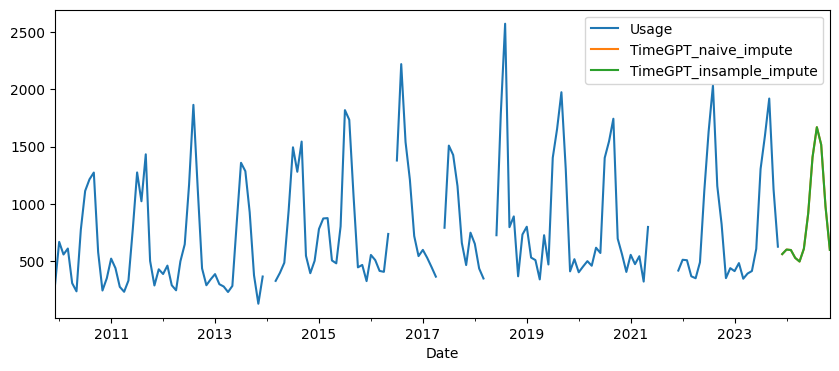

In [20]:
ax = electricity.plot(figsize=(10,4))
pd.merge(timegpt_fcst_df, timegpt_fcst_df_better, on="Date", how="outer", suffixes=("_naive_impute", "_insample_impute")).plot(ax=ax)

In [21]:
pd.merge(timegpt_fcst_df_better, timegpt_fcst_df_better, on="Date", how="outer", suffixes=("_naive_impute", "_insample_impute"))

,TimeGPT_naive_impute,TimeGPT_insample_impute
Date,,
2023-12-31,562.355347,562.355347
2024-01-31,602.121033,602.121033
2024-02-29,597.920227,597.920227
2024-03-31,529.268799,529.268799
2024-04-30,497.732147,497.732147
2024-05-31,608.737244,608.737244
2024-06-30,917.290955,917.290955
2024-07-31,1406.194458,1406.194458
2024-08-31,1668.514282,1668.514282


**Observations:**
- It seems that TimeGPT gives a high weightage to very recent points and points older than a cycle may not be getting used much. Hence, even with better imputation of older points, there is no impact on the forecast at all.
- Compared to statistical methods like ETS, this is a little different. ETS gives a high weightage to recent points but also uses older points to some extent.
- This is a good thing because it is more likely that the future will be similar to the recent past than the distant past. But it is also important to consider the distant past to capture the seasonality and trend.


**Questions:**
- What happens if missing points were in the recent past? How does TimeGPT handle that?

### Forecasting with Recent Missing Data Points

#### Naive Imputation

In [22]:
cutoff = "2021-12-31"
electricity_trimmed = electricity.copy().query("Date <= @cutoff")
electricity_trimmed.tail(12)

,Usage
Date,
2021-01-31,556.0
2021-02-28,475.0
2021-03-31,544.0
2021-04-30,323.0
2021-05-31,799.0
2021-06-30,NaN
2021-07-31,NaN
2021-08-31,NaN
2021-09-30,NaN


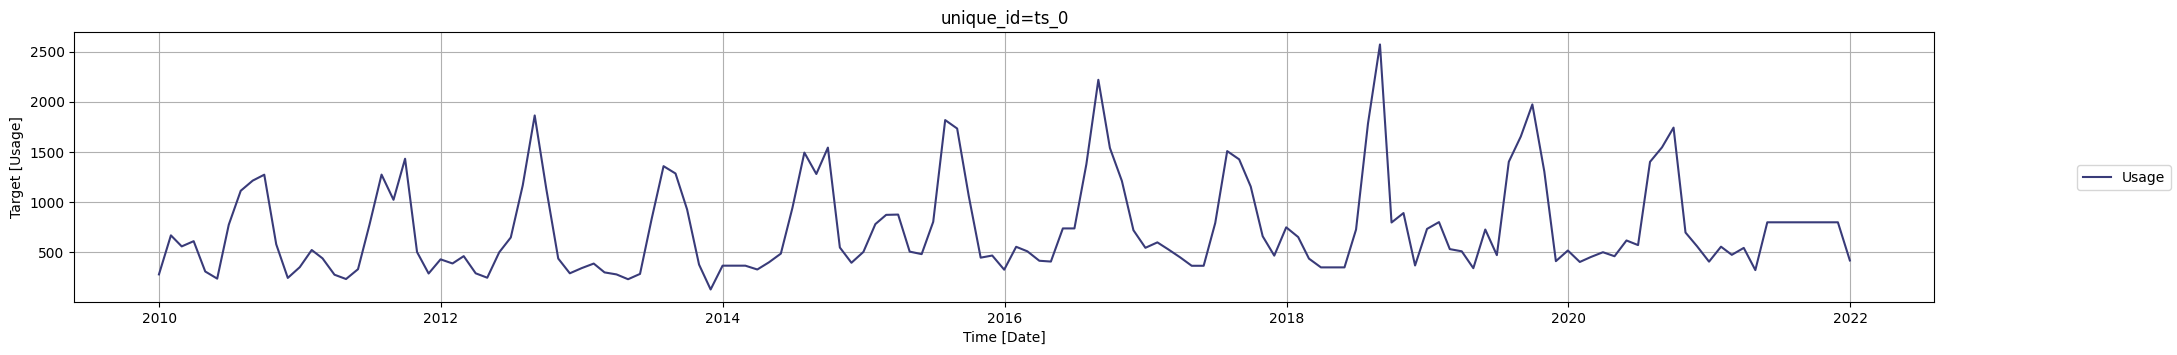

In [23]:
# Fill missing values (naive method)
electricity_trimmed_filled = electricity_trimmed.copy().fillna(method="ffill").fillna(method="bfill")
timegpt.plot(electricity_trimmed_filled.reset_index(), time_col='Date', target_col='Usage')

In [24]:
if not REUSE:
    timegpt_fcst_with_history_df_trimmed = timegpt.forecast(df=electricity_trimmed_filled.reset_index(), h=12, freq='M', time_col='Date', target_col='Usage', add_history=True)
timegpt_fcst_with_history_df_trimmed.head()

,Date,TimeGPT
0,2012-01-31,558.691406
1,2012-02-29,531.377441
2,2012-03-31,456.877045
3,2012-04-30,240.628159
4,2012-05-31,325.556580


In [25]:
timegpt_fcst_with_history_df_trimmed = add_datetime_set_index(timegpt_fcst_with_history_df_trimmed)

<AxesSubplot: xlabel='Date'>

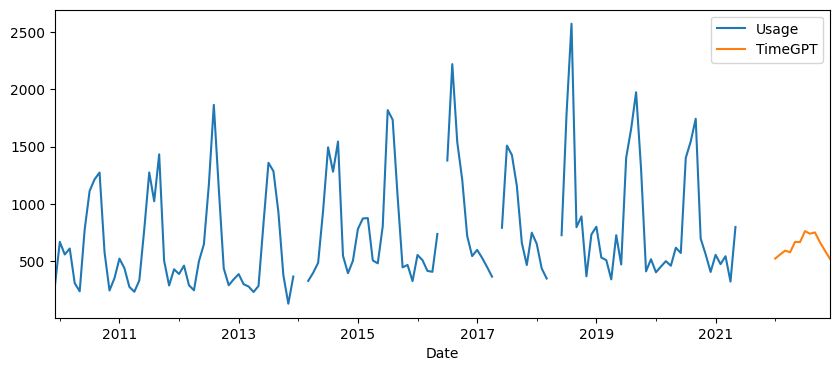

In [26]:
ax = electricity_trimmed.plot(figsize=(10,4))
timegpt_fcst_with_history_df_trimmed.query("Date > @cutoff").plot(ax=ax)

**Observations**
- Since TimeGPT gives a high weightage to recent points, it is likely that the forecast will be impacted if recent points are missing.
- This can be observed in the forecast above.

**Next Steps:**
- Let's try imputing the history with insample forecast and see if that improves the forecast.

#### Imputing with Insample Predictions

In [27]:
# Impute missing values in history with insample predictions
electricity_trimmed_imputed_timegpt = electricity_trimmed.copy()
electricity_trimmed_imputed_timegpt["Usage"] = electricity_trimmed_imputed_timegpt["Usage"].fillna(timegpt_fcst_with_history_df_trimmed["TimeGPT"])

<AxesSubplot: xlabel='Date'>

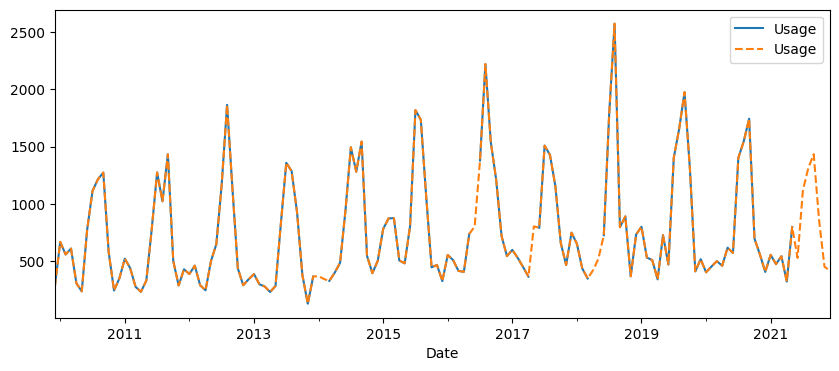

In [28]:
ax = electricity_trimmed.plot(figsize=(10,4), label="Original")
# timegpt_fcst_with_history_df.plot(ax=ax)
electricity_trimmed_imputed_timegpt.plot(ax=ax, label="Imputed", style="--")

In [29]:
if not REUSE:
    timegpt_fcst_with_history_df_trimmed_better = timegpt.forecast(
        df=electricity_trimmed_imputed_timegpt.reset_index(), h=12, freq='M', time_col='Date', target_col='Usage'
    )
timegpt_fcst_with_history_df_trimmed_better.head()

,Date,TimeGPT
0,2022-01-31,487.766602
1,2022-02-28,519.105591
2,2022-03-31,513.691895
3,2022-04-30,454.783813
4,2022-05-31,682.306763


In [30]:
timegpt_fcst_with_history_df_trimmed_better = add_datetime_set_index(timegpt_fcst_with_history_df_trimmed_better)

<AxesSubplot: xlabel='Date'>

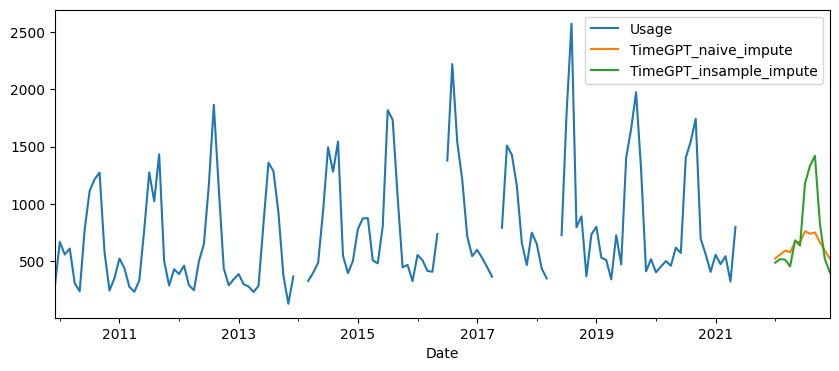

In [31]:
ax = electricity_trimmed.plot(figsize=(10,4))
pd.merge(
    timegpt_fcst_with_history_df_trimmed.query("Date > @cutoff"),
    timegpt_fcst_with_history_df_trimmed_better,
    on="Date",
    how="outer",
    suffixes=("_naive_impute", "_insample_impute")
).plot(ax=ax)

**Observations:**

- Much better forecasts with imputing recent missing values with insample forecasts.
- It is also possible that this is a short horizon model, hence, it gives recent points more weightage. The results with missing values may be better with a longer horizon model (already available from Nixtla).

### Forecasting with Missing Data Points (Short Horizon vs. Long Horizon)

In [32]:
if not REUSE:
    timegpt_fcst_with_history_df_trimmed_lh = timegpt.forecast(
        df=electricity_trimmed_filled.reset_index(), h=12, freq='M', time_col='Date', target_col='Usage', add_history=True, model='timegpt-1-long-horizon'
    )
timegpt_fcst_with_history_df_trimmed_lh.head()

,Date,TimeGPT
0,2012-01-31,579.767700
1,2012-02-29,534.208496
2,2012-03-31,497.157043
3,2012-04-30,298.317871
4,2012-05-31,345.471893


In [33]:
timegpt_fcst_with_history_df_trimmed_lh = add_datetime_set_index(timegpt_fcst_with_history_df_trimmed_lh)

<AxesSubplot: xlabel='Date'>

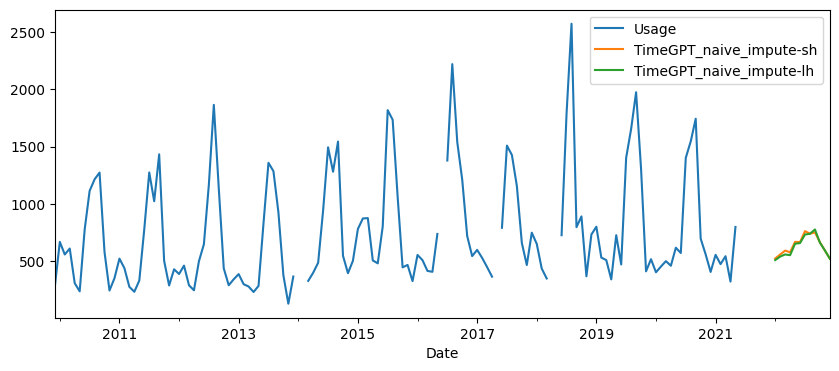

In [34]:
ax = electricity_trimmed.plot(figsize=(10,4))
pd.merge(
    timegpt_fcst_with_history_df_trimmed.query("Date > @cutoff"),
    timegpt_fcst_with_history_df_trimmed_lh.query("Date > @cutoff"),
    on="Date",
    how="outer",
    suffixes=("_naive_impute-sh", "_naive_impute-lh")
).plot(ax=ax)

In [35]:
pd.merge(
    timegpt_fcst_with_history_df_trimmed.query("Date > @cutoff"),
    timegpt_fcst_with_history_df_trimmed_lh.query("Date > @cutoff"),
    on="Date",
    how="outer",
    suffixes=("_naive_impute_sh", "_naive_impute_lh")
)

,TimeGPT_naive_impute_sh,TimeGPT_naive_impute_lh
Date,,
2022-01-31,523.390442,510.133362
2022-02-28,558.925171,540.853455
2022-03-31,592.749878,559.397217
2022-04-30,578.216492,552.925781
2022-05-31,668.899048,653.074585
2022-06-30,667.177002,658.286987
2022-07-31,762.558472,733.199463
2022-08-31,740.047363,739.437378
2022-09-30,751.555908,777.014526


**Observations:**

- Even Long horizon model is giving results similar to short horizon model.
- So to get better results with anomalies, it may be better to use insample forecast to impute missing values.

## Export Variables to save credits

In [36]:
if not REUSE:
    for forecast in [
        "timegpt_fcst_df",
        "timegpt_fcst_with_history_df",
        "timegpt_fcst_df_better",
        "timegpt_fcst_with_history_df_trimmed",
        "timegpt_fcst_with_history_df_trimmed_better",
        "timegpt_fcst_with_history_df_trimmed_lh"
        ]:
        eval(forecast).to_csv(f"../results/{forecast}.csv")

## Backup

### PyCaret

In [37]:
from pycaret.time_series import TSForecastingExperiment

In [38]:
exp = TSForecastingExperiment()
exp.setup(data=electricity_filled, target="Usage", index="Date", fh=12, session_id=42)

,Description,Value
0,session_id,42
1,Target,Usage
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(168, 1)"
5,Transformed data shape,"(168, 1)"
6,Transformed train set shape,"(156, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [39]:
model = exp.finalize_model(exp.create_model("ets"))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-11,0.8501,0.7228,188.4308,233.0679,0.2613,0.2225,0.7409
1,2020-11,1.5410,1.5834,334.6834,499.3125,0.4648,0.3524,-7.0579
2,2021-11,0.6462,0.5278,144.7453,171.5709,0.2232,0.2003,0.8968
Mean,NaT,1.0124,0.9447,222.6198,301.3171,0.3164,0.2584,-1.8067
SD,NaT,0.3829,0.4586,81.2231,142.2372,0.1061,0.0671,3.7137


In [40]:
exp.plot_model(model)

In [41]:
insample = exp.plot_model(model, plot="insample", return_data=True)
insample = insample.get("overlay_data")
insample.index = electricity.index

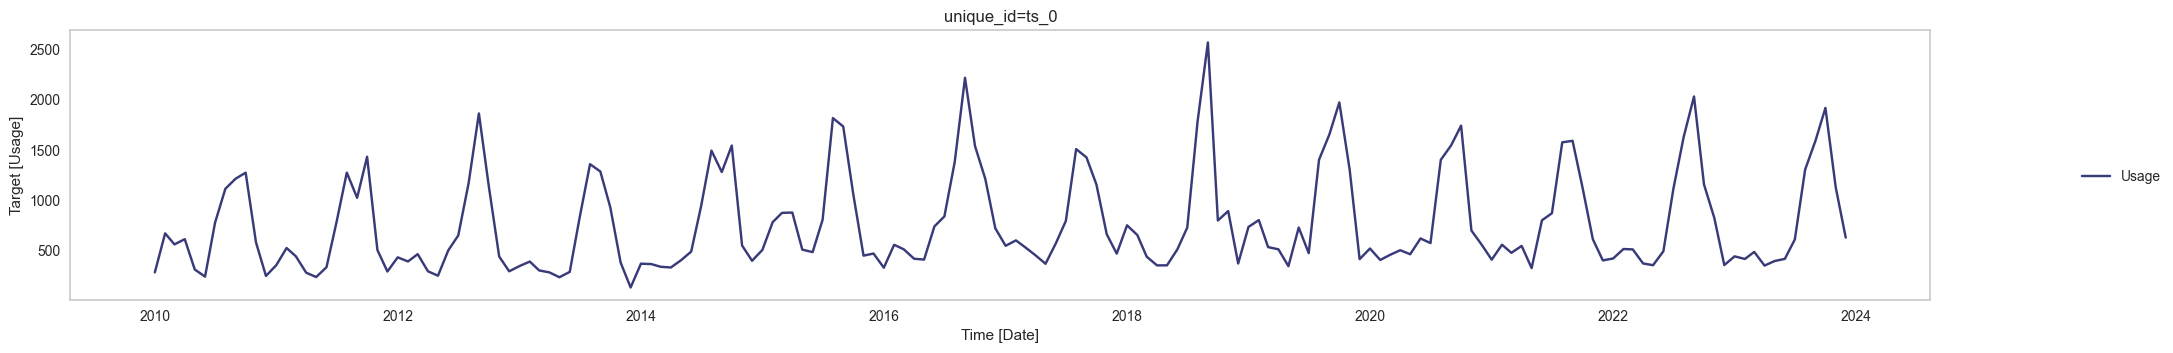

In [42]:
electricity_filled_better = electricity.copy()
electricity_filled_better['Usage'] = electricity_filled_better['Usage'].fillna(insample['ETS'])
timegpt.plot(electricity_filled_better.reset_index(), time_col='Date', target_col='Usage')

In [43]:
exp2 = TSForecastingExperiment()
exp2.setup(data=electricity_filled_better.reset_index(), target="Usage", index="Date", fh=12, session_id=42)

,Description,Value
0,session_id,42
1,Target,Usage
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(168, 1)"
5,Transformed data shape,"(168, 1)"
6,Transformed train set shape,"(156, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [44]:
model2 = exp2.finalize_model(exp2.create_model("ets"))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-11,1.0146,0.8919,221.6243,285.3682,0.3128,0.2504,0.6116
1,2020-11,0.7125,0.5957,152.6756,186.4817,0.2235,0.2022,0.8047
2,2021-11,0.6245,0.5745,131.2508,175.9839,0.1593,0.1570,0.8914
Mean,NaT,0.7839,0.6874,168.5169,215.9446,0.2319,0.2032,0.7692
SD,NaT,0.1671,0.1449,38.5578,49.2766,0.0629,0.0382,0.1170


In [45]:
exp2.plot_model([model, model2])